In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Creacion de dataframe de demandad e energía
energia = pd.DataFrame()
years = range(2000,2023)

for year in years:
    url = f"""https://raw.githubusercontent.com/adeulofeu/Datafolio/main/Tesis/Datasets/Demanda_Energia_SIN_{year}.xlsx"""
    energia_temp = pd.read_excel(url,skiprows=2,header=1,engine='openpyxl')
    energia = pd.concat([energia,energia_temp],ignore_index=True)

In [3]:
# Información general del dataframe
print(energia.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Fecha                    8400 non-null   object 
 1   Demanda Energia SIN kWh  8400 non-null   float64
 2   Generación kWh           8400 non-null   float64
 3   Demanda No Atendida kWh  7956 non-null   float64
 4   Exportaciones kWh        6893 non-null   float64
 5   Importaciones kWh        5620 non-null   float64
dtypes: float64(5), object(1)
memory usage: 393.9+ KB
None


In [4]:
# Cambio de tipo de variable a datetime64[ns] del atributo "Fecha"
energia["Fecha"] = energia["Fecha"].astype('datetime64[ns]')

In [5]:
# Revisar si hay valores nulos
energia.isnull().sum()

Fecha                         0
Demanda Energia SIN kWh       0
Generación kWh                0
Demanda No Atendida kWh     444
Exportaciones kWh          1507
Importaciones kWh          2780
dtype: int64

In [6]:
# Descripción estadística básica de los datos
energia.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Fecha,8400,2011-07-01 19:18:20.571428608,2000-01-01 00:00:00,2005-09-30 18:00:00,2011-07-01 12:00:00,2017-04-01 06:00:00,2022-12-31 00:00:00,NaN
Demanda Energia SIN kWh,8400.0,159705392.381729,86794068.28,133439390.2425,158142073.96,185106510.81,228621213.17,30400547.054343
Generación kWh,8400.0,160875004.304752,86532048.28,137087140.265,160585923.475,184695962.555,230302709.389999,29621498.992488
Demanda No Atendida kWh,7956.0,207516.835093,1000.0,37867.5,96825.0,229727.5,17208270.0,407124.315856
Exportaciones kWh,6893.0,2397361.829713,30.0,19327.74,1497964.4,4458335.98,35052391.05,2818287.174585
Importaciones kWh,5620.0,898446.796941,0.06,4686.915,35664.18,489679.0025,10111102.44,1983321.295637


In [7]:
energia["year"] = energia["Fecha"].dt.year
energia["month"] = energia["Fecha"].dt.month
energia["Fecha"] = energia["Fecha"].dt.strftime("%Y-%m-%d")

In [8]:
# Creacion de dataframe de poblacion
url ="""https://raw.githubusercontent.com/adeulofeu/Datafolio/refs/heads/main/Tesis/Datasets/Poblaci%C3%B3n.csv"""
poblacion = pd.read_csv(url)

In [9]:
# Información general del dataframe
print(poblacion.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Periodo(AAAA)  74 non-null     object
 1   Población      74 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
None


In [10]:
# Cambio de tipo de variable a datetime64[ns] del atributo "Fecha"
poblacion["Periodo(AAAA)"] = poblacion["Periodo(AAAA)"].astype('datetime64[ns]')

In [11]:
# Revisar si hay valores nulos
poblacion.isnull().sum()

Periodo(AAAA)    0
Población        0
dtype: int64

In [12]:
# Descripción estadística básica de los datos
poblacion.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Periodo(AAAA),74,1987-07-01 17:50:16.216216192,1950-12-31 00:00:00,1969-04-01 06:00:00,1987-07-01 12:00:00,2005-09-30 18:00:00,2023-12-31 00:00:00,NaN
Población,74.0,31697641.864865,13570943.0,21889817.5,31265472.0,41550931.75,52215503.0,11414523.86366


In [13]:
poblacion["year"] = poblacion["Periodo(AAAA)"].dt.year

In [14]:
# Creacion de dataframe de variables climaticas
url = """https://raw.githubusercontent.com/adeulofeu/Datafolio/refs/heads/main/Tesis/Datasets/Precipitacion_filtrado.csv"""
precipitaciones = pd.read_csv(url)

In [15]:
# Información general del dataframe
print(precipitaciones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6522 entries, 0 to 6521
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FechaObservacion  6522 non-null   object 
 1   ValorObservado    6522 non-null   float64
dtypes: float64(1), object(1)
memory usage: 102.0+ KB
None


In [16]:
precipitaciones["FechaObservacion"] = precipitaciones["FechaObservacion"].astype("datetime64[ns]")

In [17]:
# Revisar si hay valores nulos
precipitaciones.isnull().sum()

FechaObservacion    0
ValorObservado      0
dtype: int64

In [ ]:
# Descripción estadística básica de los datos
precipitaciones.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
FechaObservacion,6522,2013-12-08 06:43:36.375345152,2005-01-01 00:00:00,2009-06-20 06:00:00,2013-12-06 12:00:00,2018-05-24 18:00:00,2022-12-31 00:00:00,NaN
ValorObservado,6522.0,0.075424,0.0,0.013258,0.029018,0.058521,0.960354,0.136344


In [19]:
precipitaciones["year"] = precipitaciones["FechaObservacion"].dt.year
precipitaciones["Fecha"] = precipitaciones["FechaObservacion"].dt.strftime("%Y-%m-%d")

In [ ]:
precipitaciones.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
FechaObservacion,6522,2013-12-08 06:43:36.375345152,2005-01-01 00:00:00,2009-06-20 06:00:00,2013-12-06 12:00:00,2018-05-24 18:00:00,2022-12-31 00:00:00,NaN
ValorObservado,6522.0,0.075424,0.0,0.013258,0.029018,0.058521,0.960354,0.136344
year,6522.0,2013.437596,2005.0,2009.0,2013.0,2018.0,2022.0,5.156783


Combinación de Datasets

In [21]:
# Combianación de dataset de energía y población
energia = energia.merge(poblacion,how="left",on="year")

In [22]:
# Combianación de dataset de energía y precipitaciones
energia = energia.merge(precipitaciones,how="left",on="Fecha")

In [23]:
energia = energia.drop(columns={"Periodo(AAAA)","FechaObservacion","year_y"}).rename(columns={"year_x":"year","ValorObservado":"Precipitacion (mm)"})

In [24]:
energia.to_csv("dataset.csv")

EDA

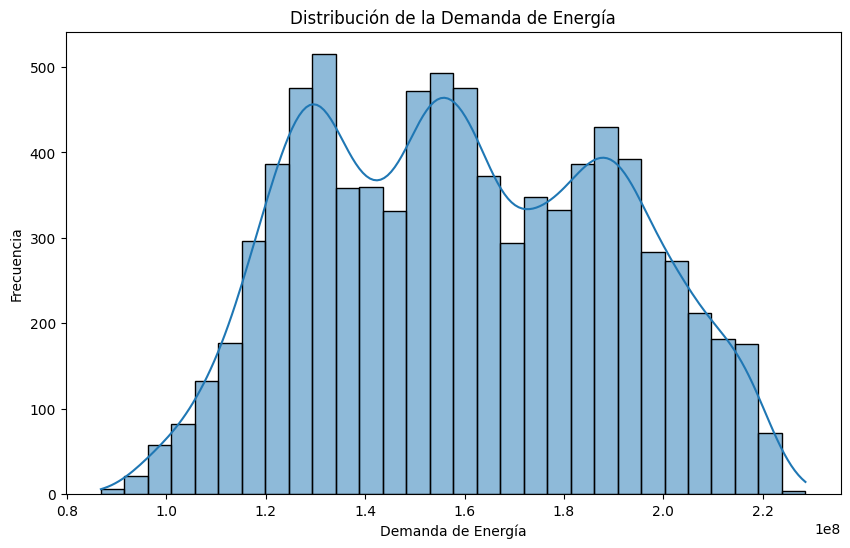

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(energia['Demanda Energia SIN kWh'], bins=30, kde=True)
plt.title('Distribución de la Demanda de Energía')
plt.xlabel('Demanda de Energía')
plt.ylabel('Frecuencia')
plt.show()

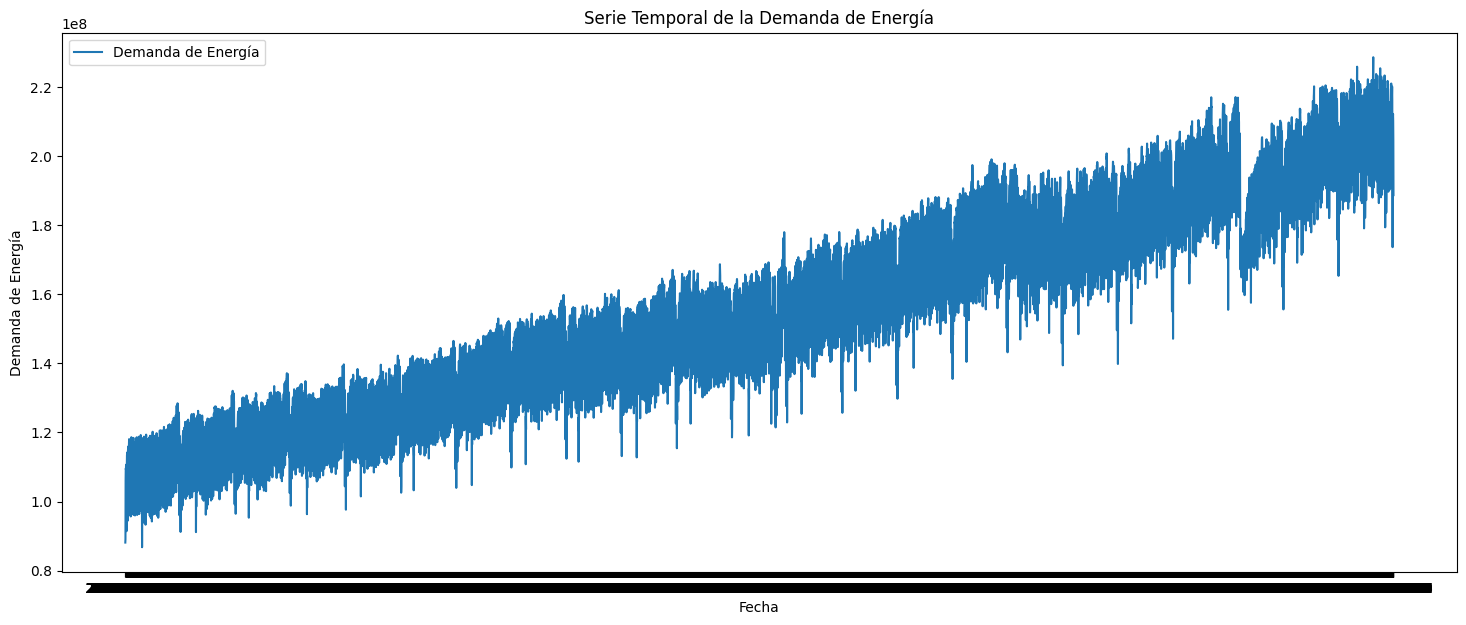

In [26]:
plt.figure(figsize=(18, 7))
plt.plot(energia['Fecha'], energia['Demanda Energia SIN kWh'], label='Demanda de Energía')
plt.title('Serie Temporal de la Demanda de Energía')
plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía')
plt.legend()
plt.show()

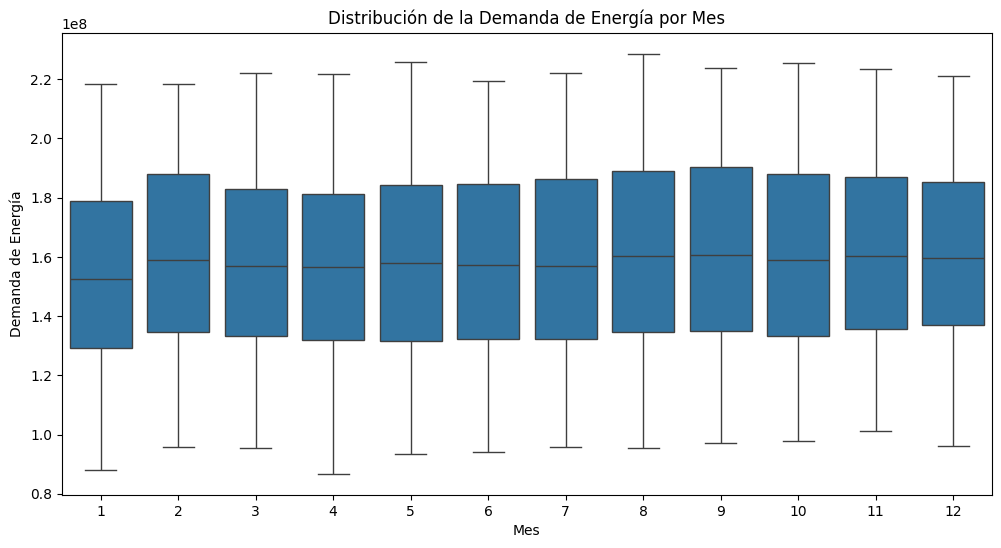

In [27]:
# Boxplot por mes
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Demanda Energia SIN kWh', data=energia)
plt.title('Distribución de la Demanda de Energía por Mes')
plt.xlabel('Mes')
plt.ylabel('Demanda de Energía')
plt.show()

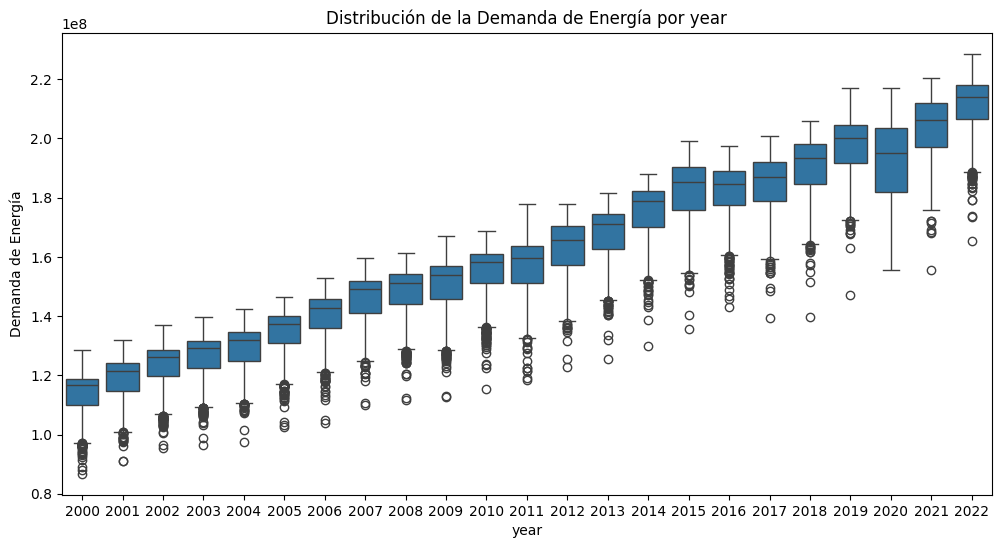

In [28]:
# Boxplot por year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='Demanda Energia SIN kWh', data=energia)
plt.title('Distribución de la Demanda de Energía por year')
plt.xlabel('year')
plt.ylabel('Demanda de Energía')
plt.show()

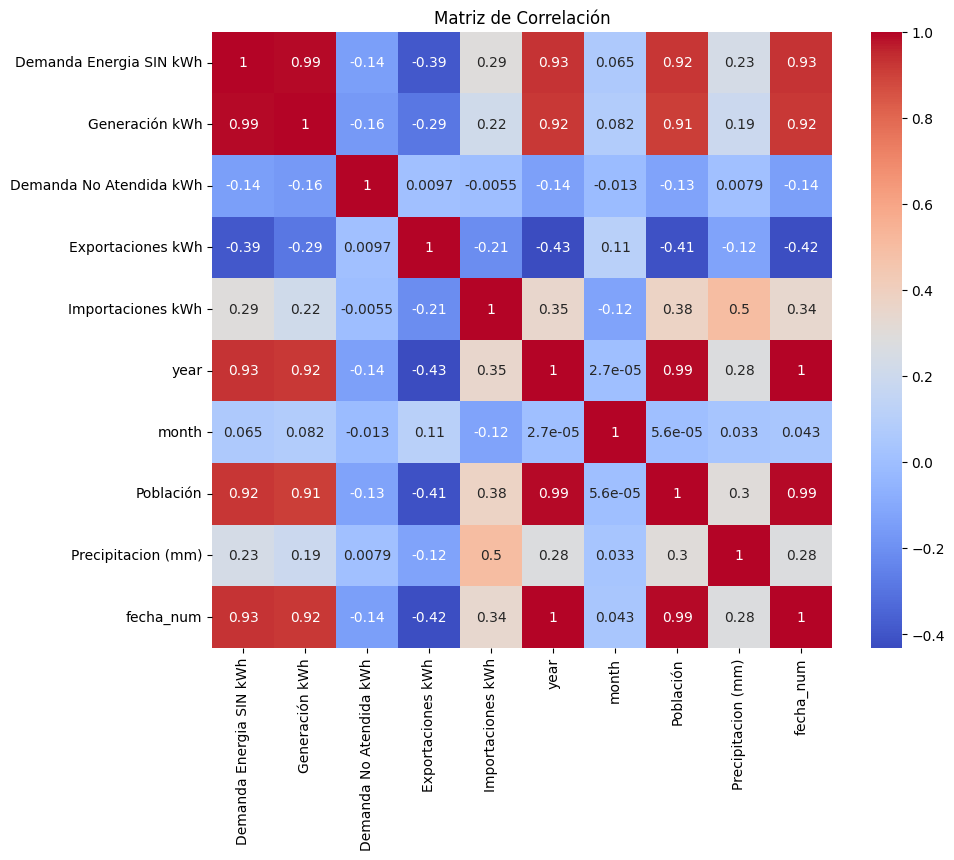

In [33]:
energia["fecha_num"] = pd.to_datetime(energia["Fecha"])
mstr = energia.drop(columns={"Fecha"})
plt.figure(figsize=(10, 8))
sns.heatmap(mstr.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

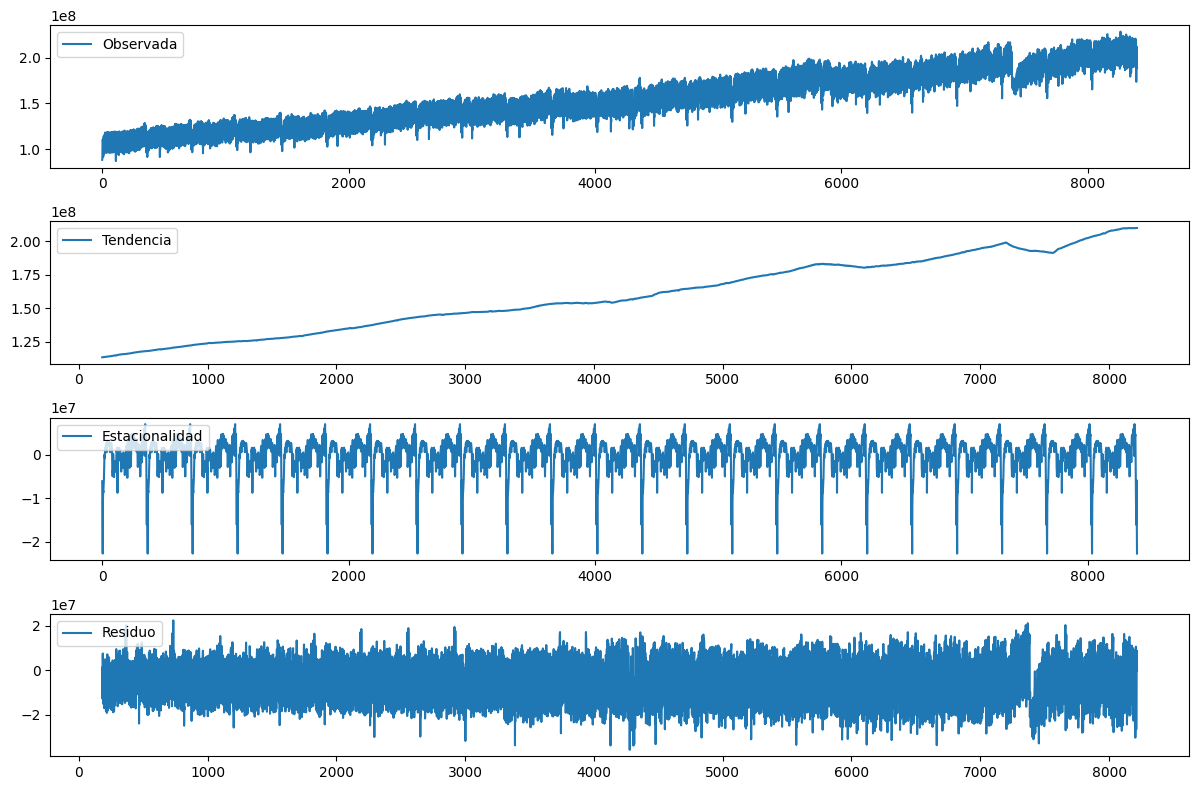

In [34]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(energia['Demanda Energia SIN kWh'], model='additive', period=365)

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observada')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

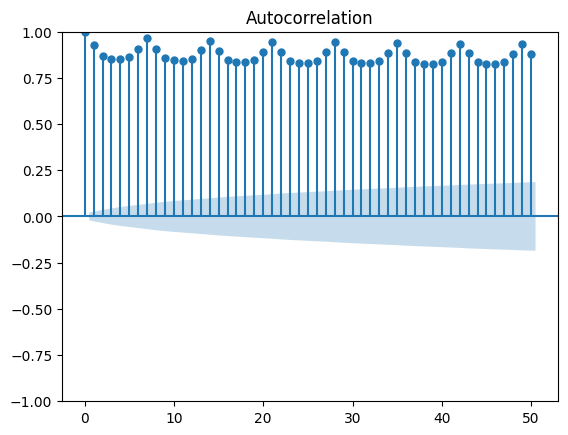

In [35]:
# Autocorrelación (ACF)
plt.figure(figsize=(10, 6))
plot_acf(energia['Demanda Energia SIN kWh'].dropna(), lags=50)
plt.show()

<Figure size 1000x600 with 0 Axes>

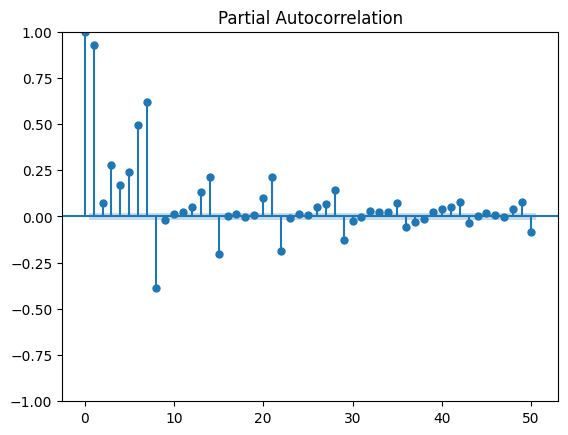

In [36]:
# Autocorrelación parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(energia['Demanda Energia SIN kWh'].dropna(), lags=50)
plt.show()

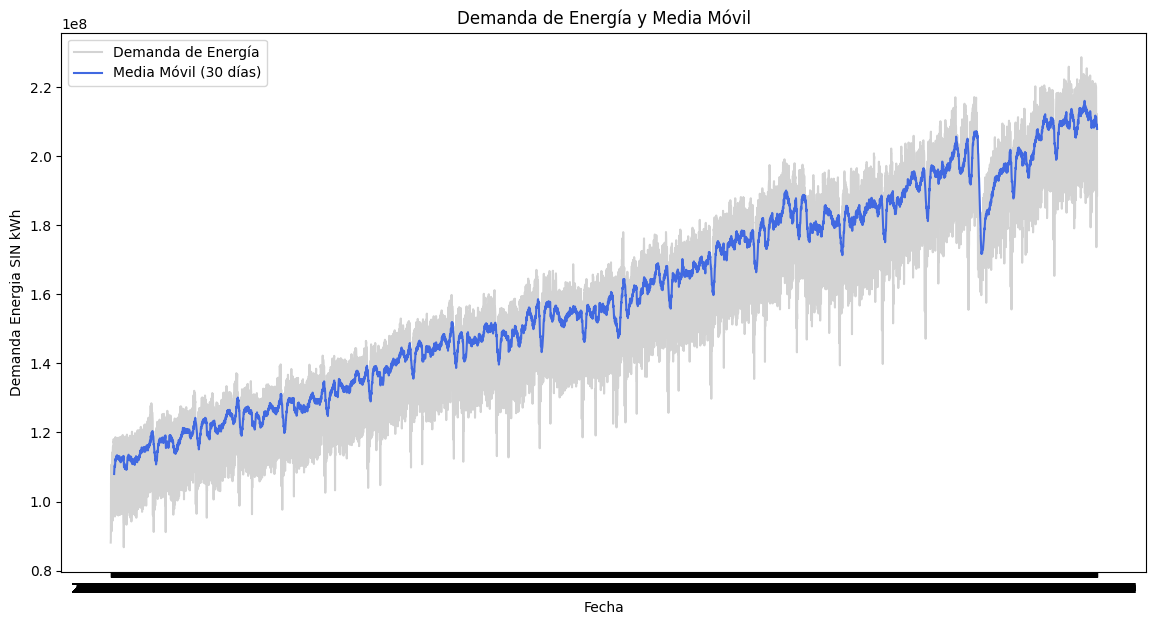

In [37]:
# Media móvil
energia['Media_Movil'] = energia['Demanda Energia SIN kWh'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(energia['Fecha'], energia['Demanda Energia SIN kWh'], label='Demanda de Energía', color='lightgrey')
plt.plot(energia['Fecha'], energia['Media_Movil'], label='Media Móvil (30 días)', color='royalblue')
plt.title('Demanda de Energía y Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Demanda Energia SIN kWh')
plt.legend()
plt.show()

Modelo LSTM

In [40]:
# Creación de datos de entrenamiento
train_size = int(len(energia) * 0.8)
train_data = energia['Demanda Energia SIN kWh'][:train_size]
test_data = energia['Demanda Energia SIN kWh'][train_size:]

# Reindexar los datos de prueba para que comiencen desde 0
test_data = test_data.reset_index(drop=True)

print(f"Longitud de los datos de entrenamiento: {len(train_data)}")
print(f"Longitud de los datos de prueba: {len(test_data)}")

Longitud de los datos de entrenamiento: 6720
Longitud de los datos de prueba: 1680


In [41]:
# Verificar la longitud de los datos de prueba
print(f"Longitud de los datos de prueba: {len(test_data)}")

# Ajustar sequence_length si es necesario
sequence_length = min(60, len(test_data) - 1)

Longitud de los datos de prueba: 1680


In [42]:
# Crear las secuencias para LSTM
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        if i + sequence_length < len(data):  # Asegurarnos de no acceder fuera del rango
            y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

In [43]:
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

x_train.shape: (6660, 60, 1), y_train.shape: (6660,)
x_test.shape: (1620, 60, 1), y_test.shape: (1620,)


In [54]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
# Creacion de historico de entrenamiento
historial = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 22945716749991936.0000 - val_loss: 40128463562080256.0000
Epoch 2/20
147/209 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 23246738122866688.0000

KeyboardInterrupt: 

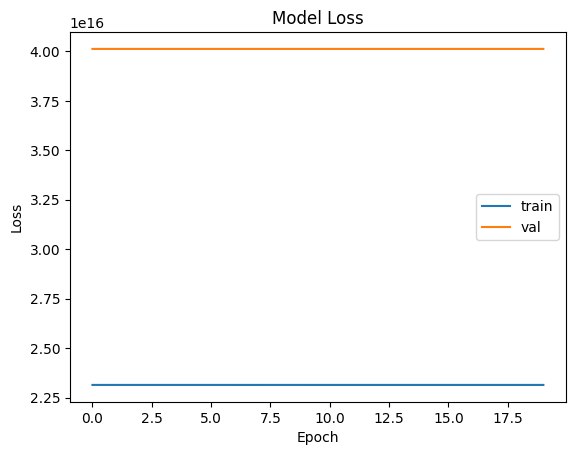

In [53]:
#Código de evaluación de la red propuesta (entrenamiento y validación)
#Código de la inspección del modelo de red mediante la función de perdida
plt.plot(historial.history['loss'], label='train')
plt.plot(historial.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Hacer predicciones
predictions = model.predict(x_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [40]:
# Imprimir las primeras predicciones para verificar
print(predictions[:10])

[[222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]
 [222.83095]]
